In [2]:
import mplhep

In [3]:
import bokeh
import time
import copy
import scipy.stats as ss
from scipy.optimize import curve_fit
from coffea import hist, processor, nanoevents, util
from coffea.nanoevents.methods import candidate
from coffea.nanoevents import NanoAODSchema, BaseSchema

import awkward as ak
import numpy as np
import glob as glob
import itertools
import pandas as pd
from numpy.random import RandomState

from dask.distributed import Client
import inspect
import matplotlib.pyplot as plt

### Import processor

In [3]:
from CoffeaJERCProcessor import Processor

In [8]:
UsingDaskExecutor = True
CoffeaCasaEnv     = False

In [9]:
# assume running on the LPC
xrootdstr = 'root://cmsxrootd.fnal.gov/'

# if running on coffea casa instead...
if CoffeaCasaEnv:
    xrootdstr = 'root://xcache/'

rootfiles = open('dataset.txt').read().split()

fileslist = [xrootdstr + file for file in rootfiles]

In [10]:
# to test on one file, uncomment the line below
fileslist = [fileslist[0]]
fileslist

['root://cmsxrootd.fnal.gov//store/mc/RunIISummer20UL18NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/20UL18JMENano_106X_upgrade2018_realistic_v16_L1v1-v1/30000/0230241E-754C-954D-B5D5-C104C1550830.root']

# Dask Setup:
---
### For Coffea-Casa, the client must be specified according to the user that is logged into the Coffea-Casa Environment.
#### 1.) go to the left of this coffea-casa session to the task bar and click the orange-red button; it will say "Dask" if you hover your cursor over it
#### 2.) scroll down to the blue box where it shows the "Scheduler Address"
#### 3.) write that full address into the dask Client function 
#### Example: `client = Client("tls://ac-2emalik-2ewilliams-40cern-2ech.dask.coffea.casa:8786")`
---
### For CMSLPC, the client must be specified with the LPCCondorCluster
#### 1.) follow installation instructions from https://github.com/CoffeaTeam/lpcjobqueue, if you have not already done so, to get a working singularity environment with access to lpcjobqueue and LPCCondorCluster class
#### 2.) import LPCCondorCluster: `from lpcjobqueue import LPCCondorCluster`
#### 3.) define the client
#### Example: 
`cluster = LPCCondorCluster()`

`client = Client(cluster)`


In [11]:
# Dask set up for Coffea-Casa only
if(UsingDaskExecutor and CoffeaCasaEnv):
    client = Client("tls://ac-2emalik-2ewilliams-40cern-2ech.dask.coffea.casa:8786")
    client.upload_file('CoffeaJERCProcessor.py')

In [14]:
# # Dask set up for LPC only 
# if(UsingDaskExecutor and not CoffeaCasaEnv):
#     from lpcjobqueue import LPCCondorCluster
#     cluster = LPCCondorCluster()
#     cluster.adapt(minimum=1, maximum=10)
#     client = Client(cluster)
#     client.upload_file('CoffeaJERCProcessor.py')
# # client

In [ ]:
tstart = time.time()

outputs_unweighted = {}

seed = 1234577890
prng = RandomState(seed)
Chunk = [10000, 5] # [chunksize, maxchunks]

# xrootdstr = 'root://cmsxrootd.fnal.gov/'
# files = [xrootdstr + "/store/mc/RunIISummer19UL17NanoAOD/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/JMECustomTuples_106X_mc2017_realistic_v6-v1/280000/0F7E67F1-5FCB-EC4B-A0B3-E0E9B98AFC43.root"]
# files = ['JMECustomTuples_106X_mc2017_realistic_v6-v1.root']

filesets = {'QCD': fileslist}

for name,files in filesets.items(): 
    if not UsingDaskExecutor:
        chosen_exec = 'futures'
        output = processor.run_uproot_job({name:files},
                                          treename='Events',
                                          processor_instance=Processor(),
                                          executor=processor.iterative_executor,
    #                                        executor=processor.futures_executor,
                                          executor_args={
                                              'skipbadfiles':False,
                                              'schema': NanoAODSchema, #BaseSchema
                                              'workers': 2},
                                          chunksize=Chunk[0])#, maxchunks=Chunk[1])
    else:
        chosen_exec = 'dask'
        output = processor.run_uproot_job({name:files},
                                          treename='Events',
                                          processor_instance=Processor(),
                                          executor=processor.dask_executor,
                                          executor_args={
                                              'client': client,
                                              'skipbadfiles':False,
                                              'schema': NanoAODSchema, #BaseSchema
#                                               'workers': 2
                                          },
                                          chunksize=Chunk[0])#, maxchunks=Chunk[1])

elapsed = time.time() - tstart
outputs_unweighted[name] = output
print(output)
util.save(output, 'CoffeaJERCOutputs_casa.coffea')


outputs_unweighted[name] = output
print(name + ' unweighted output loaded')
elapsed = time.time() - tstart

### Load coffea output file

In [5]:
# output = util.load('CoffeaJERCOutputs_19928000events.coffea')
output = util.load('out/CoffeaJERCOutputs_binned.coffea')

In [6]:
# dir(output)

In [8]:
# define gaussian function
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

In [9]:
ptbins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 20, 23, 27, 30, 35, 40, 45, 57, 72, 90, 120, 
        150, 200, 300, 400, 550, 750, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 10000 ]





In [10]:
etabins =   [-4.889,  -4.716,  -4.538,  -4.363,  -4.191,  -4.013,  -3.839,  -3.664,  -3.489,
           -3.314,  -3.139,  -2.964,  -2.853,  -2.65,  -2.5,  -2.322,  -2.172,  -2.043,  -1.93,  -1.83,
           -1.74,  -1.653,  -1.566,  -1.479,  -1.392,  -1.305,  -1.218,  -1.131,  -1.044,  -0.957,  -0.879,
           -0.783,  -0.696,  -0.609,  -0.522,  -0.435,  -0.348,  -0.261,  -0.174,  -0.087,  0,  0.087,  0.174,
           0.261,  0.348,  0.435,  0.522,  0.609,  0.696,  0.783,  0.879,  0.957,  1.044,  1.131,  1.218,
           1.305,  1.392,  1.479,  1.566,  1.653,  1.74,  1.83,  1.93,  2.043,  2.172,  2.322,  2.5,  2.65,
           2.853,  2.964,  3.139,  3.314,  3.489,  3.664,  3.839,  4.013,  4.191,  4.363,  4.538,  4.716,
           4.889, ]#5.191 ]

In [11]:
jetpt_length = len(output['jetpt'].axis('pt')[1:-1])
jeteta_length = len(output['jeteta'].axis('jeteta')[1:-1])
jeteta_length = len(etabins)

mean = np.zeros((jetpt_length, jeteta_length))
median = np.zeros((jetpt_length, jeteta_length))
width = np.zeros((jetpt_length, jeteta_length))
idx = []

In [18]:
jeteta_length

81

In [20]:
len(etabins)

81

In [12]:
for k in range(len(etabins)-1):
    print(hist.Interval(etabins[k], etabins[k+1]))
print()    
for k, etaBin in enumerate(output['jeteta'].axis('jeteta')[1:-1]):
    print(etaBin)

[-4.889, -4.716)
[-4.716, -4.538)
[-4.538, -4.363)
[-4.363, -4.191)
[-4.191, -4.013)
[-4.013, -3.839)
[-3.839, -3.664)
[-3.664, -3.489)
[-3.489, -3.314)
[-3.314, -3.139)
[-3.139, -2.964)
[-2.964, -2.853)
[-2.853, -2.65)
[-2.65, -2.5)
[-2.5, -2.322)
[-2.322, -2.172)
[-2.172, -2.043)
[-2.043, -1.93)
[-1.93, -1.83)
[-1.83, -1.74)
[-1.74, -1.653)
[-1.653, -1.566)
[-1.566, -1.479)
[-1.479, -1.392)
[-1.392, -1.305)
[-1.305, -1.218)
[-1.218, -1.131)
[-1.131, -1.044)
[-1.044, -0.957)
[-0.957, -0.879)
[-0.879, -0.783)
[-0.783, -0.696)
[-0.696, -0.609)
[-0.609, -0.522)
[-0.522, -0.435)
[-0.435, -0.348)
[-0.348, -0.261)
[-0.261, -0.174)
[-0.174, -0.087)
[-0.087, 0)
[0, 0.087)
[0.087, 0.174)
[0.174, 0.261)
[0.261, 0.348)
[0.348, 0.435)
[0.435, 0.522)
[0.522, 0.609)
[0.609, 0.696)
[0.696, 0.783)
[0.783, 0.879)
[0.879, 0.957)
[0.957, 1.044)
[1.044, 1.131)
[1.131, 1.218)
[1.218, 1.305)
[1.305, 1.392)
[1.392, 1.479)
[1.479, 1.566)
[1.566, 1.653)
[1.653, 1.74)
[1.74, 1.83)
[1.83, 1.93)
[1.93, 2.043)
[2

In [17]:
xvals = output['ptresponse'].axis('ptresponse').centers()
f_xvals = np.linspace(0,5,5001)

# mean = [[]]*len(output['jetpt'].axis('pt')[1:-1])
# median = [[]]*len(output['jetpt'].axis('pt')[1:-1])
# width = [[]]*len(output['jetpt'].axis('pt')[1:-1])
# idx = []

j = 0

# for i, ptBin in enumerate(output['jetpt'].axis('pt')[1:-1]):
    
for i in range(len(ptbins)-1):
        
    ptBin = hist.Interval(ptbins[i], ptbins[i+1])
    print('pt bin '+str(ptBin))
    
    if not 'inf' in str(ptBin):
        pt_string = '_pT'+str(int(ptBin.lo))+'to'+str(int(ptBin.hi))
    else:
        pt_string = '_pT'+str(ptBin.lo) + 'to' + str(ptBin.hi)
        pt_string = pt_string.replace('.0','').replace('-infto','0to')
    
#     for k, etaBin in enumerate(output['jeteta'].axis('jeteta')[1:-1]):
    for k in range(len(etabins)-1):
        
        etaBin = hist.Interval(etabins[k], etabins[k+1])
        
    
        
        eta_string = '_eta'+str(etaBin.lo)+'to'+str(etaBin.hi)
        eta_string = eta_string.replace('.','')

        
        
        histo = output['ptresponse'].integrate('jeteta', etaBin).integrate('pt', ptBin)
        
        histvals = np.repeat(histo.axis('ptresponse').centers(), np.array(histo.values()[('QCD',)],dtype='int'))

        yvals = histo.values()[('QCD',)]
        
        
        
        try:
            p, arr = curve_fit(gauss, xvals, yvals, p0=[10,1,1])
        except:
            continue

        
        fgaus = gauss(f_xvals, *p)
        
#         median[i,k] = f_xvals[fgaus == np.max(fgaus)]
        median[i,k] = np.median(histvals)
        mean[i,k] = p[1]
        width[i,k] = p[2]
        idx.append(i)
    print("len mean = ", len(mean))
        
        
        
        

        
        
#         h = np.max(histo.values()[('QCD',)])
#         ax = hist.plot1d(histo, overlay='dataset')
# #         plt.plot(f_xvals, fgaus)
#         plt.text(4,0.75*h,'Mean {0:0.2f}'.format(p[1]))
#         plt.text(4,0.7*h,'Median {0:0.2f}'.format(np.median(histvals)))
#         plt.text(4,0.65*h,'Width {0:0.2f}'.format(p[2]))


#         plt.savefig('ptResponse'+pt_string+eta_string+'.png')
#         plt.show()
        


pt bin [1, 2)
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean = 

pt bin [9, 10)
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =

len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =

len mean =  43
len mean =  43
pt bin [72, 90)
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean 

len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
pt bin [750, 1000)
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len me

len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =  43
len mean =

In [15]:
len(mean[1])

81

In [16]:
len(etabins)

81

In [76]:
output = util.load('CoffeaJERCOutputs_binned.coffea')

In [77]:
histo = output['ptresponse'].integrate('jeteta', hist.Interval(-0.5, 0)).integrate('pt', hist.Interval(180, 200))

histo.values()

/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Tue/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/hist/hist_tools.py:638: RuntimeWarning: Reducing along axis <Bin (name=jeteta) instance at 0x7fddefbf8c10>: requested start -0.5 between bin boundaries, no interpolation is performed
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Tue/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/hist/hist_tools.py:638: RuntimeWarning: Reducing along axis <Bin (name=pt) instance at 0x7fde0e4a89d0>: requested start 180.0 between bin boundaries, no interpolation is performed
  warnings.warn(


{('QCD',): array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          1.,   1.,   2.,   6.,  22.,  44.,  98., 130., 124.,  73.,  31.,
          3.,   6.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.])}

/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Tue/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Tue/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


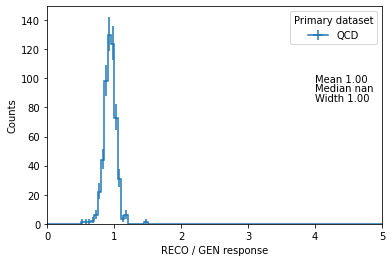

In [78]:
        h = np.max(histo.values()[('QCD',)])
        ax = hist.plot1d(histo, overlay='dataset')
#         plt.plot(f_xvals, fgaus)
        plt.savefig('ptResponse'+pt_string+eta_string+'.png')
        plt.text(4,0.75*h,'Mean {0:0.2f}'.format(p[1]))
        plt.text(4,0.7*h,'Median {0:0.2f}'.format(np.median(histvals)))
        plt.text(4,0.65*h,'Width {0:0.2f}'.format(p[2]))

        plt.show()

In [80]:
p

array([-3.32150570e-18,  9.99999999e-01,  1.00000000e+00])

In [81]:
# data = {str(ptBin):mean[i] for i, ptBin in enumerate(output['jetpt'].axis('pt')[1:-1])}
data = {str(ptBin):mean[i] for i, ptBin in enumerate(ptbins)}

# data['etaBins'] = [str(etaBin) for etaBin in output['jeteta'].axis('jeteta')[1:-1]]
data['etaBins'] = [str(etaBin) for etaBin in etabins]

df = pd.DataFrame(data=data)
df = df.set_index('etaBins')
df.to_csv('EtaBinsvsPtBinsMean.csv')

In [82]:
# data_width = {str(ptBin):width[i] for i, ptBin in enumerate(output['jetpt'].axis('pt')[1:-1])}
data_width = {str(ptBin):width[i] for i, ptBin in enumerate(ptbins)}

# data_width['etaBins'] = [str(etaBin) for etaBin in output['jeteta'].axis('jeteta')[1:-1]]
data_width['etaBins'] = [str(etaBin) for etaBin in etabins]

df_width = pd.DataFrame(data=data_width)
df_width = df_width.set_index('etaBins')
df_width.to_csv('EtaBinsvsPtBinsWidth.csv')

In [83]:
# data_median = {str(ptBin):median[i] for i, ptBin in enumerate(output['jetpt'].axis('pt')[1:-1])}
data_median = {str(ptBin):median[i] for i, ptBin in enumerate(ptbins)}

# data_median['etaBins'] = [str(etaBin) for etaBin in output['jeteta'].axis('jeteta')[1:-1]]
data_median['etaBins'] = [str(etaBin) for etaBin in etabins]

df_median = pd.DataFrame(data=data_median)
df_median = df_median.set_index('etaBins')
df_median.to_csv('EtaBinsvsPtBinsMedian.csv')

In [84]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df)
    

           1    2         3         4         5         6         7         8  \
etaBins                                                                         
-4.889   1.0  1.0  1.000000  1.000000  0.000000  1.000000  1.000000  1.000000   
-4.716   1.0  1.0  1.000000  0.000000  1.000000  1.000000  0.925049  0.976075   
-4.538   1.0  1.0  1.000000  1.000000  1.000000  1.000000  0.976075  0.750000   
-4.363   1.0  1.0  1.000000  1.000000  1.000000  1.000000  1.274597  0.750000   
-4.191   1.0  1.0  1.000000  1.000000  1.000000  1.000000  1.000000  0.000000   
-4.013   1.0  1.0  1.000000  1.000000  1.000000  1.000000  0.976075  0.977154   
-3.839   1.0  1.0  1.000000  1.000000  1.725000  0.000000  1.224830  0.999812   
-3.664   1.0  1.0  1.000000  1.000000  2.379044  0.000000  0.976075  1.124992   
-3.489   1.0  1.0  1.000000  1.000000  1.000000  1.000000  0.686810  0.643416   
-3.314   1.0  1.0  1.000000  1.000000  1.824536 -1.825562  0.375000  1.000000   
-3.139   1.0  1.0  1.000000 

In [ ]:
df

In [ ]:
# df[pt bin][eta bin]

ptBin = '300'
etaBin = '0.783'

print('mean   =', np.round(df[ptBin][etaBin],3))
print('median =', np.round(df_median[ptBin][etaBin],3))
print('width  =', np.round(df_width[ptBin][etaBin],3))

In [ ]:
# df[pt bin][eta bin]

ptBin = '300'
etaBin = '0.783'

print('mean   =', df[ptBin][etaBin])
print('median =', df_median[ptBin][etaBin])
print('width  =', df_width[ptBin][etaBin])

### Read csv


 

format for example $ 20 \text{ GeV} < p_T < 25 \text{ GeV} $ and $ 3.5 < \eta < 4.0 $


```
df = pd.read_csv('EtaBinsvsPtBinsMean.csv).set_index('etaBins')
ptBin='[20, 25)'
etaBin='[3.5, 4)'
mean = df[ptBin][etaBin]
```




In [ ]:
df_csv = pd.read_csv('EtaBinsvsPtBinsMean.csv').set_index('etaBins')

In [ ]:
df_csv

In [ ]:
df_median